# Lab Report of Group 1 (Wörner, Velez, Northe)

The source code and the binaries from the spectrum analyzer from this report can be found in our Github [repository](https://github.com/NortheLo/Microwave_Eng_Lab/tree/main/Lab4_Noise_Figures).

### Our used imports

In [11]:
import re
import numpy as np
from numpy.typing import NDArray
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat

### Some helper functions to keep the evaluation code short 

In [12]:
def read_mat(file_path: str | Path, dic_name: str) -> tuple[NDArray, NDArray, NDArray]:
    """
    Get the Gain, NF and f vector from the signal analyzer matlab file.
    """
    ws = loadmat(file_path)
    ws = ws[dic_name]

    gain = ws['gain'][0, 0].flatten()
    noise = ws['noise'][0, 0].flatten()
    f_steps = ws['f'][0, 0].flatten()

    return gain, noise, f_steps

def read_spec_csv(file_path: Path) -> tuple[list, NDArray, NDArray]:
    """
    Reads the CSV from the Spectrum Analyzer and puts the Metadata in a list, the freq bins and power
    into Numpy Arrays
    """
    # Read the entire CSV file
    with open(file_path, 'r') as f:
        content = f.read()

    # Split content into metadata and data sections using regex to find "DATA"
    parts = re.split(r'\bDATA\b', content)
    
    # Check if "DATA" section was found
    if len(parts) != 2:
        raise ValueError("No DATA section found in the file.")

    metadata_section = parts[0].strip()  # Everything before DATA
    data_section = parts[1].strip()      # Everything after DATA

    # Parse the metadata section
    metadata = {}
    for line in metadata_section.splitlines():
        if ',' in line:
            key, value = line.split(',', 1)
            metadata[key.strip()] = value.strip()

    # Parse the data section (split by newline, then split by comma)
    data = []
    for line in data_section.splitlines():
        if ',' in line:
            try:
                x, y = map(float, line.split(','))
                data.append([x, y])
            except ValueError:
                print(f"Skipping invalid line: {line}")
    
    # Convert data into numpy arrays
    data = np.array(data)
    frequencies = data[:, 0]  # First column (Frequency)
    values = data[:, 1]       # Second column (Values)

    return metadata, frequencies, values

def scientific_2_str(value: float, unit: str = "Ω") -> str:
    prefixes = [
        (1e9, 'G'),
        (1e6, 'M'),
        (1e3, 'k'),
        (1, ''),
        (1e-3, 'm'),
        (1e-6, 'µ'),
        (1e-9, 'n'),
        (1e-12, 'p')
    ]

    for factor, prefix in prefixes:
        if abs(value) >= factor:
            formatted = value / factor
            return f"{formatted:.3g} {prefix}{unit}"
    return f"{value:.3g} {unit}"  # fallback for very small values

def plot_compare(x1: NDArray, y1: NDArray,
                 x2: NDArray, y2: NDArray,
                 title: str,
                 x_label: str="Resistance [Ohm]",
                 y_label: str="Frequency [Hz]",
                 x_log: bool=False,
                 y_log: bool=False,
                 label1: str="Measurement 1",
                 label2: str="Measurement 2",
                 marker1: str='o',
                 marker2: str='s'):
    """
    Plots two datasets (x1, y1) and (x2, y2) on the same plot.
    This function assumes that x1 and x2 are frequency bins and y1 and y2 are the corresponding power bins.
    """
    
    # Align the bins to their corresponding measurements
    plt.figure(figsize=(8, 4))

    # Check if data requires log scaling
    if x_log and y_log:
        plt.loglog(x1, y1, marker=marker1, label=label1)
        plt.loglog(x2, y2, marker=marker2, label=label2)
    elif x_log:
        plt.semilogx(x1, y1, marker=marker1, label=label1)
        plt.semilogx(x2, y2, marker=marker2, label=label2)
    elif y_log:
        plt.semilogy(x1, y1, marker=marker1, label=label1)
        plt.semilogy(x2, y2, marker=marker2, label=label2)
    else:
        plt.plot(x1, y1, marker=marker1, label=label1)
        plt.plot(x2, y2, marker=marker2, label=label2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot(x: NDArray, 
             y: NDArray,
             title: str,
             x_label: str="Resistance [Ohm]",
             y_label: str="Frequency [Hz]",
             x_log: bool=False,
             y_log: bool=False,
             marker: str='o'):

    plt.figure(figsize=(8, 4))

    if x_log and y_log:
        plt.loglog(x, y, marker=marker)
    elif x_log:
        plt.semilogx(x, y, marker=marker)
    elif y_log:
        plt.semilogy(x, y, marker=marker)
    else:
        plt.plot(x, y, marker=marker)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Overview of Measurement Files
Files can be found under ``Meassurements/``

| File Name                     | Description                                       |
|------------------------------|---------------------------------------------------|
| `meassurement_5_1.mat`       | NF measurement of a filter         |
| `meassurement_5_2.mat`       | NF measurement of an attenuator                   |
| `meassurement_5_3.mat`       | NF measurement of LNA     |
| `meassurement_5_4.mat`       | NF of LNA → Attenuator |
| `meassurement_5_4_inverse.mat` | NF of Attenuator → LNA |


### CSV-File Overview
Files can be found under ``Meassurements/``
| Filename            | Description            |
|---------------------|------------------------|
| `Ampcor_0001.csv`   | no DUT + no NS         |
| `Ampcor_0002.csv`   | no DUT + NS            |
| `Ampcor_0003.csv`   | DUT + no NS            |
| `Ampcor_0004.csv`   | DUT + NS               |

## 5.1 Filter

We calculated the results below with some MATLAB code.

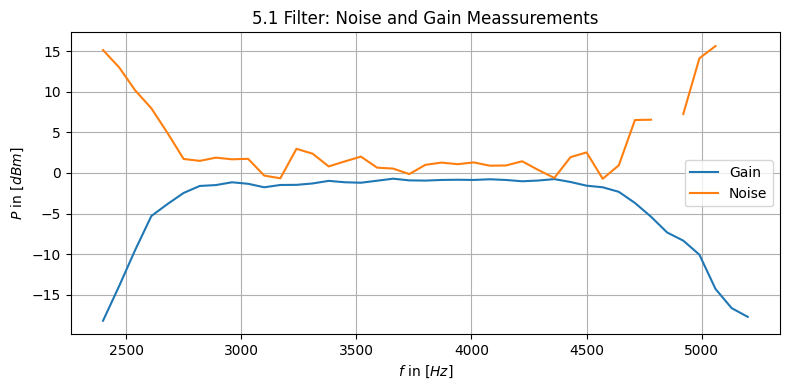

In [13]:
title_filter = "5.1 Filter: Noise and Gain Meassurements"
filter_gain, filter_noise, filter_f_steps = read_mat('Meassurements/meassurement_5_1.mat', 'messung_5_1_filter')


plot_compare(x1=filter_f_steps, y1=filter_gain,
             x2=filter_f_steps, y2=filter_noise,
             title=title_filter, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

In [ ]:
# search all the indices which are below our 3dB threshold
# and then search for the last and the first one
peak_gain = np.max(filter_gain)
threshold = peak_gain - 3

crossing_indices = np.where(filter_gain <= threshold)[0]

if crossing_indices.size >= 2:
    peak_index = np.argmax(filter_gain)
    
    lower_idx = crossing_indices[crossing_indices < peak_index][-1]
    f1, f2 = filter_f_steps[lower_idx], filter_f_steps[lower_idx + 1]
    g1, g2 = filter_gain[lower_idx], filter_gain[lower_idx + 1]
    f_3db_low = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)

    upper_idx = crossing_indices[crossing_indices > peak_index][0]
    f1, f2 = filter_f_steps[upper_idx - 1], filter_f_steps[upper_idx]
    g1, g2 = filter_gain[upper_idx - 1], filter_gain[upper_idx]
    f_3db_high = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)
    f_center = (f_3db_high - f_3db_low) / 2 + f_3db_low

    print(f"Lower -3 dB frequency: {f_3db_low:.2f} Hz")
    print(f"Upper -3 dB frequency: {f_3db_high:.2f} Hz")
    print(f"Estimated center frequency: {f_center:.2f} Hz")
else:
    print("Could not find two -3 dB crossing points.")



Lower -3 dB frequency: 2686.30 Hz
Upper -3 dB frequency: 4710.45 Hz
Estimated center frequency: 3698.38 Hz


In [34]:
# we divide as we have steps normed to MHz 
f_min = 3e9 / 1e6
f_max = 4.3e9 / 1e6 

mask = (filter_f_steps >= f_min) & (filter_f_steps <= f_max)
gain_in_band = filter_gain[mask]

if gain_in_band.size > 0:
    gain_max = np.max(gain_in_band)
    gain_min = np.min(gain_in_band)
    ripple = gain_max - gain_min

    print(f"Transmission ripple between 3 GHz and 4.3 GHz: {ripple:.2f} dB")
else:
    print("No data points found in the 3 GHz to 4.3 GHz range.")

Transmission ripple between 3 GHz and 4.3 GHz: 1.06 dB


## 5.2 Attenuator (6 dB)

Insert result here

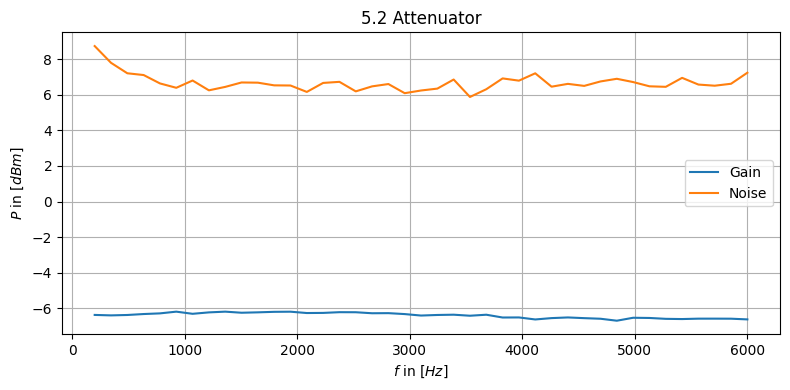

In [14]:
title_att = "5.2 Attenuator"
att_gain, att_noise, att_f_steps  = read_mat('Meassurements/meassurement_5_2.mat', 'messung_5_2_att')

plot_compare(x1=att_f_steps, y1=att_gain,
             x2=att_f_steps, y2=att_noise,
             title=title_att, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

## 5.3 Low noise amplifier (LNA)

Insert result here

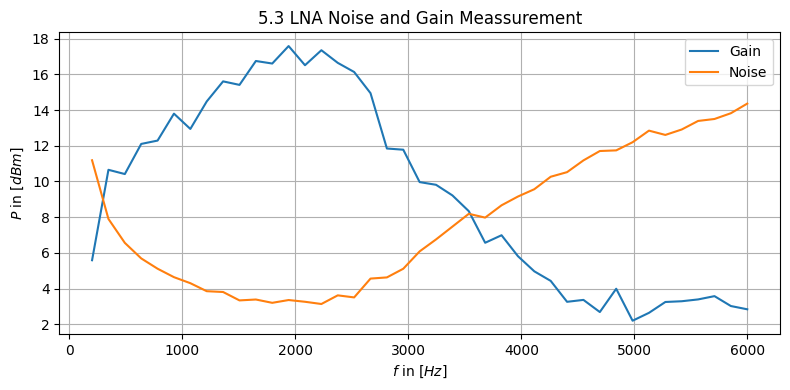

In [19]:
title_lna = "5.3 LNA Noise and Gain Meassurement"
lna_gain, lna_noise, lna_f_steps = read_mat('Meassurements/meassurement_5_3.mat', 'messung_5_3_LNA')


plot_compare(x1=lna_f_steps, y1=lna_gain,
             x2=lna_f_steps, y2=lna_noise,
             title=title_lna, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
            y_label="$P$ in $[dBm]$")

In [36]:
max_gain = np.max(lna_gain)
f_max_gain = lna_f_steps[np.argmax(lna_gain)]
print(f"LNA gain is max @ {f_max_gain} Hz with {max_gain:.2f} dB")

min_noise = np.min(lna_noise)
f_min_noise = lna_f_steps[np.argmin(lna_noise)]
print(f"LNA noise is min @ {f_min_noise} Hz with {min_noise:.2f} dB")


LNA gain is max @ 1940 Hz with 17.59 dB
LNA noise is min @ 2230 Hz with 3.13 dB


## 5.4 LNA with subsequent 6 dB attenuator

Insert result here

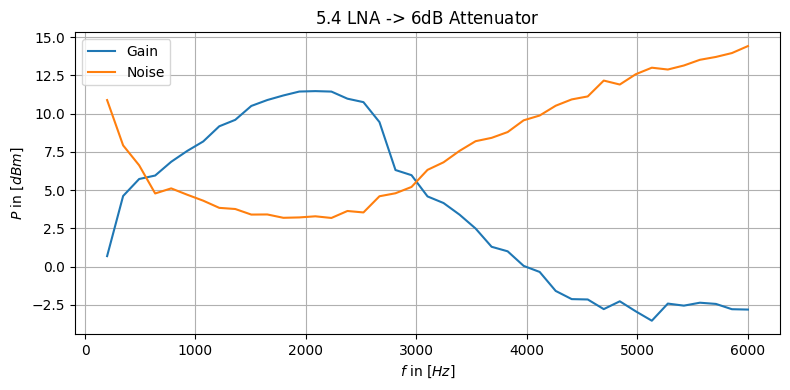

In [20]:
title_lna_att = "5.4 LNA -> $6$dB Attenuator"
lna_att_gain, lna_att_noise, lna_att_f_steps = read_mat('Meassurements/meassurement_5_4.mat', 'messung_5_4_LNA_Att')

plot_compare(x1=lna_att_f_steps, y1=lna_att_gain,
             x2=lna_att_f_steps, y2=lna_att_noise,
             title=title_lna_att, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

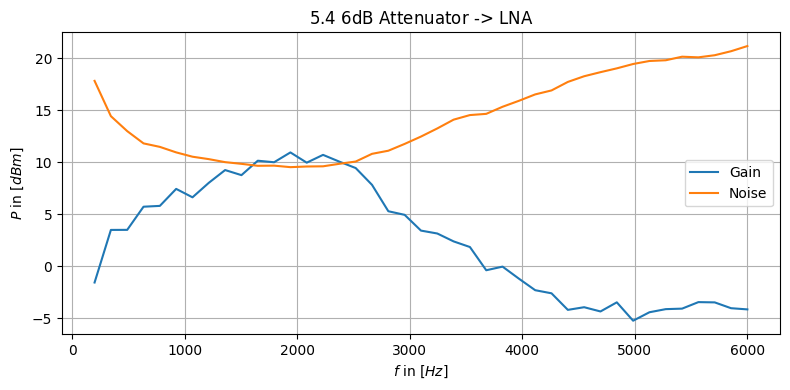

In [21]:
title_att_lna = "5.4 $6$dB Attenuator -> LNA"
att_lna_gain, att_lna_noise , att_lna_f_steps = read_mat('Meassurements/meassurement_5_4_inverse.mat', 'messung_5_4_LNA_Att_reverse')

plot_compare(x1=att_lna_f_steps, y1=att_lna_gain,
             x2=att_lna_f_steps, y2=att_lna_noise,
             title=title_att_lna, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[Hz]$",
             y_label="$P$ in $[dBm]$")

## 5.5 Noise figure measurement of the LNA with Y-Factor method

$\red {Remove \space this  \space example}$ <br>
This is used as a test if we can load in the csv file at all

In [18]:


meta_data, freq_bins, pwr_bins = read_spec_csv("Meassurements/Ampcor_0001.csv")

title_filter = "Task 3.2.3 a): "
plot(freq_bins, pwr_bins, title_filter, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed